In [1]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

Changed working directory to: D:\mtg-modeling


In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import src.plots.annotate as anno
import src.plots.symbols as symbols

In [3]:
set_code = "All_Sets"
set_codes_order = ["MKM", "OTJ", "MH3", "BLB"]

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{set_code}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{set_code}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{set_code}_Game_PD_Cards.parquet"

In [6]:
df_draft = pl.scan_parquet(draft_file)
df_summary = pl.scan_parquet(summary_file)

Mulligans are a crucial strategy in MTG. If a player's starting hand is not ideal, they can draw a new one, each time with one fewer card. This process can be repeated as needed, creating a challenging trade-off between a poor hand and a smaller one.

In @fig-mulligan-distro, we observe the distribution of mulligans by the number of re-draws. Most players do not take a mulligan; about 12% take one mulligan, and 2% take two. Very few players take three or more mulligans, with only two instances of a player taking five mulligans, resulting in a starting hand of just two cards.

We also see that 17Lands players are slightly less likely to take mulligans compared to their opponents, likely due to a combination of superior deck construction and more informed mulligan decisions.

In [7]:
df_games = pl.scan_parquet(game_file)

sum_df = df_summary.collect().to_pandas()
mean_mulligan_rate = (sum_df["n_mul"] / sum_df["n_games"]).values[0]

df_mul = df_games.unpivot(
    index=["num_mulligans"],
    on=["num_mulligans", "opp_num_mulligans"],
    variable_name="Player",
    value_name="mulligan_count",
)


df_mul2 = df_mul.collect().to_pandas()

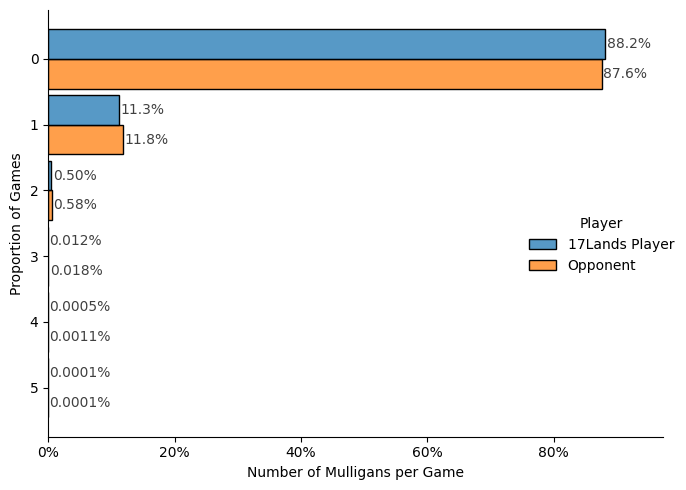

In [8]:
# | label: fig-mulligan-distro
# | fig-cap: "Distribution of Mulligans."


g = sns.displot(
    data=df_mul2,
    y="mulligan_count",
    hue="Player",
    multiple="dodge",
    stat="proportion",
    common_norm=False,
    discrete=True,
    shrink=0.9,
    element="bars",
)

anno.set_labels_to_percent()
anno.annotate_bars()
anno.set_axis_labels_and_show(
    xlabel="Number of Mulligans per Game",
    ylabel="Proportion of Games",
    reverse_y=True,
    legend=g._legend,
    legend_labels={
        "num_mulligans": "17Lands Player",
        "opp_num_mulligans": "Opponent",
    },
)

A side note on probability distributions: the player mulligan distributions appear to resemble Poisson distributions, with the number of mulligans taken being a discrete event.

Using the mean number of mulligans per game, 0.136, I performed random sampling from a Poisson distribution with $\lambda=0.136$. The results, shown in @fig-mulligan-poisson, closely match the actual data, though the real data shows a slightly higher number of games with one mulligan and slightly fewer for other values.

We can further investigate this pattern when we explore the card data to identify random draw events that correlate with mulligan decisions, such as the number of lands in the starting hand.

In [9]:
n_games = df_games.collect().shape[0]

df_games = df_games.with_columns(
    pl.Series(np.random.poisson(lam=mean_mulligan_rate, size=n_games)).alias(
        "sampled_mul"
    )
)

df_mul_sample = df_games.unpivot(
    index=["draft_id"],
    on=["num_mulligans", "sampled_mul"],
    variable_name="Distribution",
    value_name="mulligan_count",
)


df_mul_sample = df_mul_sample.collect().to_pandas()

NameError: name 'np' is not defined

In [10]:
# | label: fig-mulligan-poisson
# | fig-cap: "Distribution of Player Mulligans vs Poisson Distribution."

custom_palette = {
    "num_mulligans": "#1f77b4",
    "sampled_mul": "#2ca02c",
}

g = sns.displot(
    data=df_mul_sample,
    y="mulligan_count",
    hue="Distribution",
    multiple="dodge",
    stat="proportion",
    common_norm=False,
    discrete=True,
    shrink=0.8,
    element="bars",
    palette=custom_palette,
)

plt.gca().set(xlim=(0, 1))
anno.set_labels_to_percent()
anno.annotate_bars()
anno.set_axis_labels_and_show(
    xlabel="Number of Mulligans per Game",
    ylabel="Proportion of Games",
    reverse_y=True,
    legend=g._legend,
    legend_labels={
        "num_mulligans": "Mulligan Count - Data",
        "sampled_mul": "Mulligan Count - Poisson",
    },
)

NameError: name 'df_mul_sample' is not defined

We now examine the outcomes of games where mulligans occur. In @fig-player-vs-opponent-mulligan-wins, we see a clear near-linear relationship between the number of mulligans and win rates, with win rates decreasing by approximately 15% for each mulligan taken.

When comparing 17Lands players to their opponents, the rate of win decay is consistent, maintaining an 8-9% gap in favor of 17Lands players at each mulligan level.

This data does not reveal the causal relationship between mulligans and win rates. It’s unclear whether mulligans are inherently detrimental or simply indicative of bad starting hands that would have had an even lower probability of winning. This question could be further explored using card data to assess the quality of starting hands that led to mulligans.


In [11]:
df_mul_win = (
    df_games.group_by(["num_mulligans"])
    .agg(
        pl.col("won").count().alias("n_games"),
        pl.col("won").sum().alias("n_wins"),
        pl.col("won").mean().alias("win_rate"),
    )
    .with_columns((pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"))
    .sort(by="num_mulligans", descending=False)
    .collect()
).to_pandas()

df_mul_win_opp = (
    df_games.with_columns((1 - pl.col("won")).alias("opp_won"))
    .group_by(["opp_num_mulligans"])
    .agg(
        pl.col("opp_won").count().alias("n_games"),
        pl.col("opp_won").sum().alias("n_wins"),
        pl.col("opp_won").mean().alias("win_rate"),
    )
    .with_columns((pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"))
    .sort(by="opp_num_mulligans", descending=False)
    .collect()
).to_pandas()

df_mul_win = df_mul_win.merge(
    df_mul_win_opp,
    left_on="num_mulligans",
    right_on="opp_num_mulligans",
    suffixes=("", "_opp"),
)

df_mul_win_m = df_mul_win.melt(
    id_vars=["num_mulligans"],
    value_vars=["win_rate", "win_rate_opp"],
    var_name="Player",
    value_name="Win Rate",
)

df_mul_win_m["Player"] = df_mul_win_m["Player"].replace(
    {"win_rate": "Player Win Rate", "win_rate_opp": "Opponent Win Rate"}
)

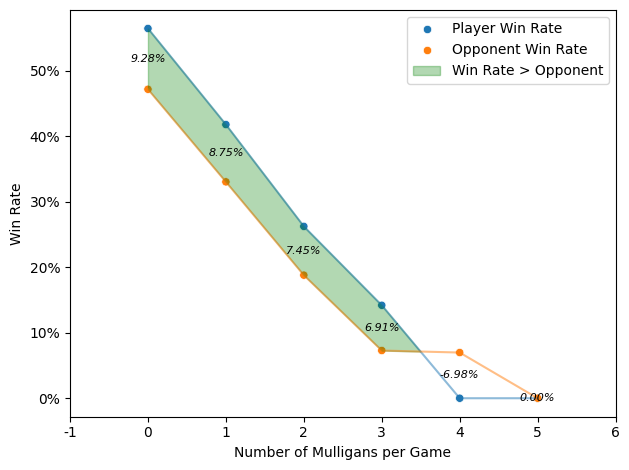

In [12]:
# | label: fig-player-vs-opponent-mulligan-wins
# | fig-cap: "Win Rates for Players and Opponents by Mulligans."

sns.scatterplot(data=df_mul_win_m, x="num_mulligans", y="Win Rate", hue="Player")
sns.lineplot(
    data=df_mul_win_m,
    x="num_mulligans",
    y="Win Rate",
    hue="Player",
    legend=False,
    alpha=0.5,
)

plt.fill_between(
    df_mul_win["num_mulligans"],
    df_mul_win["win_rate"],
    df_mul_win["win_rate_opp"],
    where=(df_mul_win["win_rate"] > df_mul_win["win_rate_opp"]),
    interpolate=True,
    color="green",
    alpha=0.3,
    label="Win Rate > Opponent",
)

for i, (x, y1, y2) in enumerate(
    zip(df_mul_win["num_mulligans"], df_mul_win["win_rate"], df_mul_win["win_rate_opp"])
):
    plt.text(
        x,
        (y1 + y2) / 2,
        f"{(y1 - y2):.2%}",
        ha="center",
        va="center",
        fontsize=8,
        fontstyle="italic",
    )

plt.ylim = (0, 0.6)
anno.set_labels_to_percent(axis="y")
anno.set_labels_to_ints(axis="x")
anno.set_axis_labels_and_show(
    xlabel="Number of Mulligans per Game",
    ylabel="Win Rate",
    legend=True,
)